In [9]:

from __future__ import print_function
import six
import sys
import os
from optparse import OptionParser
from keras.models import load_model, Model, model_from_json
from argparse import ArgumentParser
from keras import backend as K
from keras.layers import Input
import numpy as np
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
import h5py
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from keras.optimizers import Adam, Nadam
import pandas as pd
from keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import yaml
from train import get_features

In [10]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputFile tree config outputDir")

options = Option(
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_lstm.yml',
    outputDir = '/'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
print(yamlConfig)

Loading configuration from train_config_lstm.yml
{'Inputs': ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR', 'j1_pdgid', 'j_index'], 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'], 'KerasModel': 'lstm_model', 'KerasModelRetrain': 'lstm_model_constraint', 'KerasLoss': 'categorical_crossentropy', 'L1Reg': 0.0001, 'L1RegR': 0.001, 'NormalizeInputs': 1, 'InputType': 'Conv1D', 'MaxParticles': 20}


In [29]:
from __future__ import print_function
from keras.layers import Dense, Dropout, Flatten, Convolution2D, merge, Convolution1D, Conv2D, Conv1D, Input, SpatialDropout1D, GRU, MaxPooling1D, AveragePooling1D, SimpleRNN, LSTM, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.regularizers import l1
import h5py

def lstm_model(Inputs, nclasses, l1Reg=0,l1RegR=0):
    """
    Basic LSTM model
    """
    x = LSTM(16,return_sequences=False,  kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu',kernel_initializer='lecun_uniform',name='lstm_lstm')(Inputs)
    #x = Flatten()(x)
    x = Dropout(0.1)(x)
    predictions = Dense(nclasses, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
    model = Model(inputs=Inputs, outputs=predictions)
    print(model.summary())
    return model


In [12]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)


C:\Users\Azure\Desktop\ML git\train.py:29: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5119909,)
('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_index', '

In [30]:
keras_model = lstm_model(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], l1Reg=yamlConfig['L1Reg'] )
startlearningrate=0.0001
adam = Adam(lr=startlearningrate)
keras_model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])
callbacks=None

keras_model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                validation_split = 0.25, shuffle = True, callbacks = None)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 20, 6)             0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 16)                1472      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 85        
Total params: 1,557
Trainable params: 1,557
Non-trainable params: 0
_________________________________________________________________
None
Train on 14889 samples, validate on 4963 samples
Epoch 1/100
14889/14889 [==============================] - 1s 47us/step - loss: 2.2948 - accuracy: 0.0484 - val_loss: 2.2226 - val_accuracy: 0.0476
Epoch 2/100
14889/14889 [============================

Epoch 50/100
14889/14889 [==============================] - 0s 23us/step - loss: 0.2341 - accuracy: 0.9017 - val_loss: 0.2298 - val_accuracy: 0.9021
Epoch 51/100
14889/14889 [==============================] - 0s 23us/step - loss: 0.2343 - accuracy: 0.9011 - val_loss: 0.2279 - val_accuracy: 0.9027
Epoch 52/100
14889/14889 [==============================] - 0s 22us/step - loss: 0.2320 - accuracy: 0.9012 - val_loss: 0.2261 - val_accuracy: 0.9027
Epoch 53/100
14889/14889 [==============================] - 0s 23us/step - loss: 0.2293 - accuracy: 0.9033 - val_loss: 0.2243 - val_accuracy: 0.9031
Epoch 54/100
14889/14889 [==============================] - 0s 23us/step - loss: 0.2276 - accuracy: 0.9029 - val_loss: 0.2225 - val_accuracy: 0.9033
Epoch 55/100
14889/14889 [==============================] - 0s 22us/step - loss: 0.2259 - accuracy: 0.9031 - val_loss: 0.2209 - val_accuracy: 0.9037
Epoch 56/100
14889/14889 [==============================] - 0s 23us/step - loss: 0.2244 - accuracy: 0.9033

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Text(0.25, 0.9, 'LSTM')

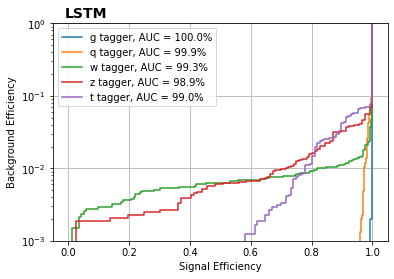

In [33]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = keras_model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'LSTM',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

In [34]:
def gru_model(Inputs, nclasses, l1Reg=0,l1RegR=0):
    """
    Basic GRU model
    """
    x = GRU(20,kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu', recurrent_activation='sigmoid', name='gru_selu',)(Inputs)
    #x = GRU(20,kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='selu', recurrent_activation='hard_sigmoid', name='gru_selu',)(Inputs)
    x = Dense(20,kernel_regularizer=l1(l1Reg),activation='relu', kernel_initializer='lecun_uniform', name='dense_relu')(x)
    x = Dropout(0.1)(x)
    predictions = Dense(nclasses, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
    model = Model(inputs=Inputs, outputs=predictions)
    print(model.summary())
    return model

In [35]:
Option = namedtuple("MyStruct", "inputFile tree config outputDir")

options = Option(
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_gru.yml',
    outputDir = '/'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
print(yamlConfig)

Loading configuration from train_config_gru.yml
{'Inputs': ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR', 'j1_pdgid', 'j_index'], 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'], 'KerasModel': 'gru_model', 'KerasModelRetrain': 'gru_model_constraint', 'KerasLoss': 'categorical_crossentropy', 'L1Reg': 0.0001, 'L1RegR': 0.001, 'NormalizeInputs': 1, 'InputType': 'Conv1D', 'MaxParticles': 20}


In [36]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)


C:\Users\Azure\Desktop\ML git\train.py:29: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5119909,)
('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_index', '

In [37]:
keras_model = gru_model(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], l1Reg=yamlConfig['L1Reg'] )
startlearningrate=0.0001
adam = Adam(lr=startlearningrate)
keras_model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])
callbacks=None

keras_model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                validation_split = 0.25, shuffle = True, callbacks = None)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 20, 6)             0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1620      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________
None
Train on 14889 samples, validate on 4963 samples
Epoch 1/100
14889/14889 [==============================] - 1s 63us/st

Epoch 49/100
14889/14889 [==============================] - 0s 30us/step - loss: 0.3562 - accuracy: 0.8360 - val_loss: 0.3438 - val_accuracy: 0.8398
Epoch 50/100
14889/14889 [==============================] - 0s 29us/step - loss: 0.3508 - accuracy: 0.8404 - val_loss: 0.3394 - val_accuracy: 0.8436
Epoch 51/100
14889/14889 [==============================] - 0s 30us/step - loss: 0.3467 - accuracy: 0.8435 - val_loss: 0.3355 - val_accuracy: 0.8469
Epoch 52/100
14889/14889 [==============================] - 0s 31us/step - loss: 0.3425 - accuracy: 0.8478 - val_loss: 0.3320 - val_accuracy: 0.8499
Epoch 53/100
14889/14889 [==============================] - 0s 29us/step - loss: 0.3386 - accuracy: 0.8492 - val_loss: 0.3287 - val_accuracy: 0.8521
Epoch 54/100
14889/14889 [==============================] - 0s 30us/step - loss: 0.3350 - accuracy: 0.8518 - val_loss: 0.3256 - val_accuracy: 0.8541
Epoch 55/100
14889/14889 [==============================] - 0s 30us/step - loss: 0.3318 - accuracy: 0.8553

Text(0.25, 0.9, 'LSTM')

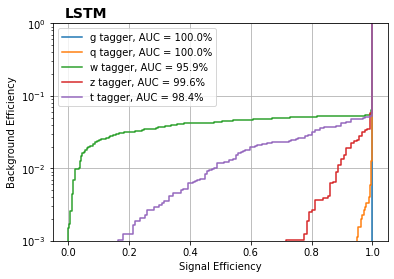

In [38]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = keras_model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'LSTM',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)